# UCB and Active Arm Elimination

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from abc import ABC

class AbstractArm(ABC):
    
    def pull(self, n):
        pass
    
    def get_mean(self):
        return self.mu

class BernoulliArm(AbstractArm):
    
    def __init__(self, mu):
        self.mu = mu
    
    def pull(self, n=1):
        if n > 1:
            # returns array of booleans
            return np.random.rand(n) < self.mu
        else:
            # returns boolean (no an array)
            return np.random.rand() < self.mu

    
class Bandit:

    def __init__(self, arms):
        self.arms = arms
        self.num_arms = len(arms)
        
        self.opt_arm = np.argmax([arm.get_mean() for arm in arms])
        self.opt_arm_mean = arms[self.opt_arm].get_mean()
        
    def get_opt_arm(self):
        return self.opt_arm
    
    def get_opt_arm_mean(self):
        return self.opt_arm_mean
        
    def get_num_arms(self):
        return self.num_arms
    
    def pull_arm(self, i, n=1):
        return self.arms[i].pull(n)
    
    def pull_all_arms(self, n):
        results = np.zeros((self.num_arms, n))
    
        for i in range(self.num_arms):
            results[i] = self.pull_arm(i, n)
            
        return results

In [3]:
# Note that UCB never stops exploring; it just explores
# less and less as we become more confident in which arm is best. 
# However, once we are very 
def UCB(bandit, delta, n):
    
    k = bandit.get_num_arms()
    
    arm_pull_count = np.zeros(k)
    arm_reward_total = np.zeros(k)
    index = np.array([np.inf for i in range(k)])
    
    rewards = np.zeros(n)
    
    for i in range(n):
        
        # choose arm
        best_arm = np.argmax(index)
        reward = bandit.pull_arm(best_arm)
        
        arm_pull_count[best_arm] += 1
        arm_reward_total[best_arm] += reward
        exploration_bonus = np.sqrt(2*np.log(1/delta)/arm_pull_count[best_arm])
        
        # update UCB index for chosen arm
        index[best_arm] = arm_reward_total[best_arm]/arm_pull_count[best_arm] + exploration_bonus
        
        rewards[i] = reward
        
    return rewards

In [4]:
def test_UCB():
    b0 = BernoulliArm(0.2)
    b1 = BernoulliArm(0.5)
    b2 = BernoulliArm(0.8)
    arms = [b0, b1, b2]
    bandit = Bandit(arms)
    rewards = UCB(bandit, 0.1, 10)
    print(rewards)
    
test_UCB()

[0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]


In [5]:
def compute_cumulative_regret(bandit, rewards):
    mu_opt = bandit.get_opt_arm_mean()
    regrets = [mu_opt - rewards[i] for i in range(len(rewards))]
    return np.cumsum(regrets)

def UCB_expected_regret(n, num_trials):
    b0 = BernoulliArm(0.2)
    b1 = BernoulliArm(0.5)
    b2 = BernoulliArm(0.8)
    arms = [b0, b1, b2]
    bandit = Bandit(arms)
    
    delta = 0.01
    
    all_rewards = np.zeros((num_trials, n))
    
    for t in range(num_trials):
        rewards = UCB(bandit, delta, n)
        all_rewards[t] = rewards
     
    expected_rewards = np.sum(all_rewards, axis=0)/num_trials
    
    return compute_cumulative_regret(bandit, expected_rewards)

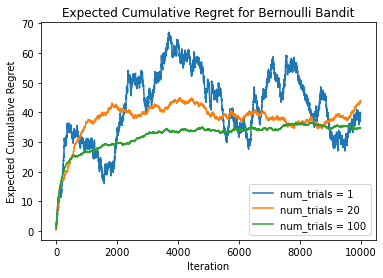

In [9]:
def plot_expected_regret_UCB():
    
    num_trials_vec = [1,20,100]
    
    for num_trials in num_trials_vec:
        expected_regret = UCB_expected_regret(10000, num_trials)
        plt.plot(expected_regret, label='num_trials = ' + str(num_trials))
        
    plt.title('Expected Cumulative Regret for Bernoulli Bandit')
    plt.ylabel('Expected Cumulative Regret')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
    
plot_expected_regret_UCB()

In [7]:
# Active Arm Elimination
def Elimination(bandit, delta, n):
    
    k = bandit.get_num_arms()
    
    arm_pull_count = np.zeros(k)
    arm_reward_total = np.zeros(k)
    index = np.array([np.inf for i in range(k)])
    
    rewards = np.zeros(n)
    
    lower = np.zeros(k)
    
    num_iterations = 0
    valid_arms = [i for i in range(k)]
    
    while(len(valid_arms) > 1):
        for i in valid_arms:
            num_iterations += 1
            
            reward = bandit.pull_arm(i)
            
            arm_pull_count[i] += 1
            arm_reward_total[i] += reward
            exploration_bonus = np.sqrt(2*np.log(1/delta)/arm_pull_count[i])

            # update UCB index for chosen arm
            index[i] = arm_reward_total[i]/arm_pull_count[i] + exploration_bonus
            lower[i] = arm_reward_total[i]/arm_pull_count[i] - exploration_bonus
                  
            # eliminate arm if it's upper bound is lower than another's lower bound
            for j in range(i+1, k):
                if index[i] - lower[j] < 0:
                    # eliminate arm i
                    valid_arms.remove(i)

                    
    # explotation phase
    best_arm = valid_arms[0]

    for i in range(num_iterations, n):
        
        reward = bandit.pull_arm(best_arm)
        rewards[i] = reward
        
    return rewards

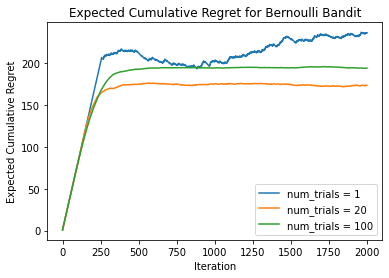

In [10]:
def Elimination_expected_regret(n, num_trials):
    b0 = BernoulliArm(0.2)
    b1 = BernoulliArm(0.5)
    b2 = BernoulliArm(0.8)
    arms = [b0, b1, b2]
    bandit = Bandit(arms)
    
    delta = 0.3
    
    all_rewards = np.zeros((num_trials, n))
    
    for t in range(num_trials):
        rewards = Elimination(bandit, delta, n)
        all_rewards[t] = rewards
     
    expected_rewards = np.sum(all_rewards, axis=0)/num_trials
    
    return compute_cumulative_regret(bandit, expected_rewards)

def plot_expected_regret_UCB():
    
    num_trials_vec = [1, 20, 100]
    
    for num_trials in num_trials_vec:
        expected_regret = Elimination_expected_regret(2000, num_trials)
        plt.plot(expected_regret, label='num_trials = ' + str(num_trials))
        
    
        
    plt.title('Expected Cumulative Regret for Bernoulli Bandit')
    plt.ylabel('Expected Cumulative Regret')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
    
plot_expected_regret_UCB()